In [205]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [207]:
forward = pd.read_csv('./5_flood/payment_forwarding_log.csv')
forward

,Payment_ID,From_Node_ID,To_Node_ID,Arrival_time
0,0,4311,476,101
1,1,4690,3543,104
2,2,4239,150,106
3,11,1014,342,117
4,13,3744,2,120
...,...,...,...,...
162899,29624,844,343,105409
162900,29897,1029,282,105458
162901,29695,4171,8,105524
162902,29977,569,58,105593


In [209]:
forward = forward.sort_values(by=['From_Node_ID', 'To_Node_ID', 'Arrival_time'])
forward['time_diff'] = forward.groupby(['From_Node_ID', 'To_Node_ID'])['Arrival_time'].diff().fillna(0)
forward['inv_time_diff_ms'] = forward['time_diff'].apply(lambda x: 1 / x if x > 0 else 0)
forward

,Payment_ID,From_Node_ID,To_Node_ID,Arrival_time,time_diff,inv_time_diff_ms
19264,5141,0,6049,7915,0.0,0.000000
19779,5141,0,6049,8315,400.0,0.002500
24658,5141,0,6049,11715,3400.0,0.000294
24955,5141,0,6049,11914,199.0,0.005025
25240,5141,0,6049,12113,199.0,0.005025
...,...,...,...,...,...,...
101541,13150,6505,5747,45610,4990.0,0.000200
103200,28118,6505,5747,46210,600.0,0.001667
142315,13150,6505,5747,67804,21594.0,0.000046
152132,13150,6505,5747,77401,9597.0,0.000104


In [211]:
transaction_count = forward.groupby(['From_Node_ID','To_Node_ID']).size().reset_index(name='transaction_count')
forward = forward.merge(transaction_count, on=['From_Node_ID', 'To_Node_ID'], how='left')
transaction_count

,From_Node_ID,To_Node_ID,transaction_count
0,0,6049,15
1,1,2,2
2,1,6,2
3,1,80,1
4,1,98,1
...,...,...,...
24334,6505,348,6
24335,6505,501,3
24336,6505,1324,2
24337,6505,5747,6


In [213]:
#unique_to_nodes = forward.groupby('To_Node_ID')['From_Node_ID'].nunique().reset_index(name='unique_to_nodes')
#forward = forward.merge(unique_to_nodes, on='To_Node_ID', how='left')
#unique_to_nodes

In [215]:


#forward['inv_time_diff_ms'] = forward['inv_time_diff_ms'] / 100
#forward['transaction_count'] = forward['transaction_count'] * 100
features = forward[['inv_time_diff_ms', 'transaction_count']].fillna(0)
features

,inv_time_diff_ms,transaction_count
0,0.000000,15
1,0.002500,15
2,0.000294,15
3,0.005025,15
4,0.005025,15
...,...,...
162899,0.000200,6
162900,0.001667,6
162901,0.000046,6
162902,0.000104,6


In [217]:

iso_forest = IsolationForest(n_estimators=100, contamination=0.35, random_state=42)

pd.set_option('display.max_rows', 1000)
iso_forest.fit(features)

y_pred = iso_forest.predict(features)

forward['anomaly'] = y_pred

#forward.to_csv('updated_forward.csv', index=False)

forward['is_fraud'] = forward['anomaly'].apply(lambda x: 1 if x == -1 else 0)

#forward.to_csv('fraud_forward.csv', index=False)
fraud_transactions = forward[forward['is_fraud'] == 1]

fraud_transactions


,Payment_ID,From_Node_ID,To_Node_ID,Arrival_time,time_diff,inv_time_diff_ms,transaction_count,anomaly,is_fraud
1,5141,0,6049,8315,400.0,0.002500,15,-1,1
5,5141,0,6049,12310,197.0,0.005076,15,-1,1
6,5141,0,6049,12712,402.0,0.002488,15,-1,1
8,5141,0,6049,16108,198.0,0.005051,15,-1,1
9,5141,0,6049,16311,203.0,0.004926,15,-1,1
...,...,...,...,...,...,...,...,...,...
162873,11718,6504,5747,57147,904.0,0.001106,11,-1,1
162888,16935,6505,348,26101,199.0,0.005025,6,-1,1
162890,13150,6505,348,68004,397.0,0.002519,6,-1,1
162891,13150,6505,348,68202,198.0,0.005051,6,-1,1


In [218]:
forward['anomaly_score'] = iso_forest.decision_function(features)
print(forward[['anomaly_score', 'is_fraud']])
#forward.to_csv('anomaly_score.csv', index=False)

        anomaly_score  is_fraud
0            0.046189         0
1           -0.001880         1
2            0.086246         0
3            0.011770         0
4            0.011770         0
...               ...       ...
162899       0.070961         0
162900      -0.065375         1
162901       0.068814         0
162902       0.070507         0
162903       0.022102         0

[162904 rows x 2 columns]


In [219]:
features.join(forward[['anomaly_score']]).corr()

,inv_time_diff_ms,transaction_count,anomaly_score
inv_time_diff_ms,1.000000,0.094244,-0.263528
transaction_count,0.094244,1.000000,-0.493440
anomaly_score,-0.263528,-0.493440,1.000000


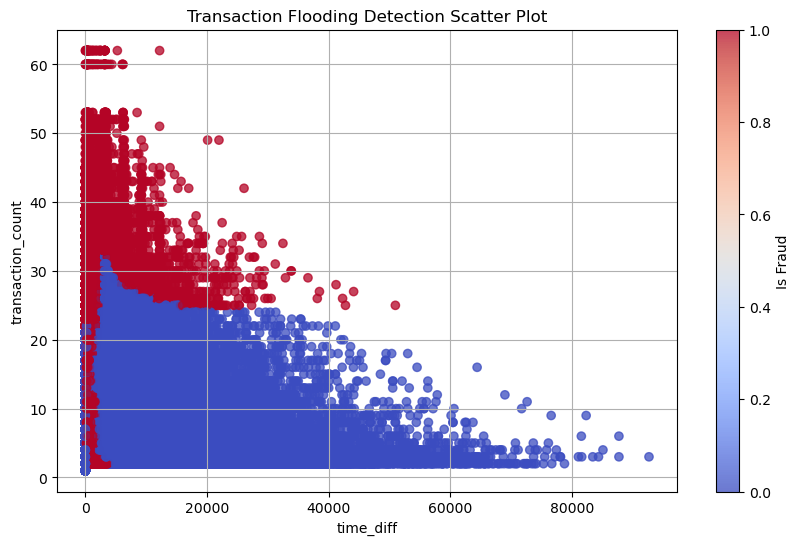

In [223]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))


plt.scatter(forward['time_diff'], forward['transaction_count'], c=forward['is_fraud'], cmap='coolwarm', label='Flooding Attack (1 = Fraud)', alpha=0.75)

plt.title('Transaction Flooding Detection Scatter Plot')
plt.xlabel('time_diff')
plt.ylabel('transaction_count')
plt.colorbar(label='Is Fraud')
plt.grid(True)
plt.show()
